## CNN VXL-Net - TFM Emilio Pomares Porras MUIA Alfonso X el Sabio, 2023-2024

### Sistema de visión artificial para manipulación robótica a tasas interactivas con arquitecturas basadas en UNet: VXL-Net

#### Artificial vision system for robotic manipulation at interactive framerates with U-Net based architectures: VXL-Net

# ETAPA DE ENTRENAMIENTO - TRAINING STAGE

In [77]:
# Python >= 3.10 is required

import sys
print(sys.version)

assert (int(str(sys.version).split(".")[0])*100 + int(str(sys.version).split(".")[1]))>=310, "Please upgrade to pytorch ^3.10"

3.10.14 (main, May  6 2024, 19:42:50) [GCC 11.2.0]


In [78]:
# Imports y variables globales

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torchvision.transforms as transforms

import os

import struct

import scipy
from scipy import ndimage

import numpy as np

import cv2

import matplotlib.pyplot as plt
from matplotlib.ticker import FixedLocator

import time

import wandb

import random

import pickle

from tqdm import tqdm

In [79]:
IMG_SIZE = 256
N_CHANNELS = 6
BATCH_SIZE = 32

In [80]:
# Device detection

device = "cuda" if torch.cuda.is_available() else ("mps" if torch.backends.mps.is_available() else "cpu")
device = "cpu"
print(f"Chosen device: {device}")

Chosen device: cpu


## Utils

In this section we will include all auxiliary functions needed to load the data from disk and prepare the minibatches on the fly to be fed into the model

In [81]:
def plot_3d(data, aspect='equal', double_axis=True, ax=None):
    """
    Plots a 3D grid of scalar-valued voxels.

    Parameters:
    data (numpy.array): data (len(data.shape) should be 3)
    aspect (str): Aspect ratio for the plot (default is 'equal')
    double_axis (bool): Whether to scale the tick labels by a factor of 2
    ax (matplotlib.axes._subplots.Axes3DSubplot, optional): The axis to plot on. 
                                                           If None, a new figure and axis are created.
    """

    def explode(data):
        size = np.array(data.shape) * 2
        data_e = np.zeros(size - 1, dtype=data.dtype)
        data_e[::2, ::2, ::2] = data
        return data_e

    def explode_2(data):
        size = np.array(data.shape) * 2
        size[3] = data.shape[3]
        data_e = np.zeros((size[0] - 1, size[1] - 1, size[2] - 1, data.shape[3]), dtype=data.dtype)
        data_e[::2, ::2, ::2, :] = data
        return data_e

    filled = data
    colors = np.zeros(filled.shape + (4,))
    colors[..., 3] = filled  # Use tensor values for the alpha channel
    colors[..., :3] = plt.cm.viridis(filled)[..., :3]  # Assign colors using the viridis colormap

    # Upscale the above voxel image, leaving gaps
    filled_2 = explode(filled)
    colors_2 = explode_2(colors)

    # Shrink the gaps
    x, y, z = np.indices(np.array(filled_2.shape) + 1).astype(float) // 2
    x[0::2, :, :] += 0.05
    y[:, 0::2, :] += 0.05
    z[:, :, 0::2] += 0.05
    x[1::2, :, :] += 0.95
    y[:, 1::2, :] += 0.95
    z[:, :, 1::2] += 0.95

    # Create a new figure and axis only if ax is None
    if ax is None:
        fig = plt.figure()
        ax = fig.add_subplot(projection='3d')

    ax.voxels(x, y, z, filled_2, facecolors=colors_2)
    ax.set_aspect(aspect)

    if double_axis:
        # Scale the tick labels by a factor of 2
        xticks = ax.get_xticks()
        yticks = ax.get_yticks()
        zticks = ax.get_zticks()
    
        # Set the tick positions (using FixedLocator)
        ax.xaxis.set_major_locator(FixedLocator(xticks))
        ax.yaxis.set_major_locator(FixedLocator(yticks))
        ax.zaxis.set_major_locator(FixedLocator(zticks))
    
        # Now set the tick labels
        ax.set_xticklabels(np.round(xticks * 2, 2))
        ax.set_yticklabels(np.round(yticks * 2, 2))
        ax.set_zticklabels(np.round(zticks * 2, 2))

In [82]:
def gaussian_kernel(sigma, size=3):
    """
    Generates a Gaussian kernel of a given size and standard deviation.

    Parameters:
    sigma (float): Standard deviation of the Gaussian distribution.
    size (int): Size of the kernel. Default is 3.

    Returns:
    numpy.ndarray: Gaussian kernel.
    """
    kernel_range = np.linspace(-(size - 1) / 2, (size - 1) / 2, size)
    x, y, z = np.meshgrid(kernel_range, kernel_range, kernel_range)
    kernel = np.exp(-(x ** 2 + y ** 2 + z ** 2) / (2 * sigma ** 2))
    kernel /= np.sum(kernel)
    #print(np.min(kernel))
    return kernel

def apply_gaussian_smoothing(array, sigma):
    """
    Applies Gaussian smoothing to a 3D array.

    Parameters:
    array (numpy.ndarray): Input array of shape (W, H, D).
    sigma (float): Standard deviation of the Gaussian kernel.

    Returns:
    numpy.ndarray: Smoothed array.
    """
    kernel = gaussian_kernel(sigma)
    return ndimage.convolve(array, kernel)

In [83]:
def get_padded_size(data, N):
    """
    Calculates padding sizes for F.pad so that each dimension is a multiple of N
    """
    n_dim = len(data.shape)
    dims = []
    for dim in range(n_dim):
        l = data.shape[dim]
        needed = ((N-(l-(l//N)*N))%N)
        needed_low = needed//2
        needed_high = needed-needed_low
        dims.append(needed_low)
        dims.append(needed_high)
    return tuple(dims[::-1])

In [84]:
def print_layer_output_shapes(model: nn.Module, input_tensor: torch.Tensor):
    """Prints out output shape for all layers in the network"""
    def register_hook(module):
        def hook(module, input, output):
            class_name = module.__class__.__name__
            layer_output_shape = output.shape
            print(f"{class_name}: {layer_output_shape}")
        return hook

    # Register hooks for each layer in the model
    hooks = []
    for layer in model.children():
        hooks.append(layer.register_forward_hook(register_hook(layer)))

    # Forward pass to trigger the hooks
    model(input_tensor)

    # Remove the hooks after the forward pass
    for hook in hooks:
        hook.remove()

In [85]:
def debug(condition, msg, level=0, name=""):
    """
    Conditionally outputs text, with
    informative formatting
    
    Parameters:
    condition (bool): A condition that will evaluate to True or False
    msg (str): The string to conditionally print
    level (int): The formatting tabulation level
    name (str): An optional informative label
    """
    if condition:
        prefix = ""
        for i in range(level):
            prefix += "   "
        print(f"{prefix} ({name}) {msg}")

In [86]:
def count_parameters(model):
    """
    Counts the total number of parameters in a PyTorch model

    Parameters:
    model (nn.Module): PyTorch model

    Returns:
    total_params (int): Total number of parameters
    total_size (int): Total size of all parameters in bytes
    """
    total_params = sum(p.numel() for p in model.parameters())
    total_size = sum(p.numel() * p.element_size() for p in model.parameters())
    
    return total_params, total_size, f"{total_params//(1000000)}M", f"{total_size//(1024*1024)}MB"

In [87]:
def list_frozen_layers(model: nn.Module):
    """
    Lists layers and prints their trainability status
    """
    layers_status = []
    for name, param in model.named_parameters():
        layer_name = name.split('.')[0]  # Get the layer name
        is_frozen = not param.requires_grad
        layers_status.append((name, is_frozen))
    
    for layer, is_frozen in layers_status:
        status = "Frozen" if is_frozen else "Trainable"
        print(f"Layer: {layer}, Status: {status}")

## Data inspection and pre-processing
Let's inspect some data first and assemble datapoints for the model

In [116]:
# Let's load a few datapoints, consisting of and L and R 1280x720 images plus binary occupancy grid

DATASET_PATH = "../reduced-dataset/train"

import struct

def load_target_datapoint(file_path, dataset_path=""):
    # Define the format string for reading the binary data
    format_string = "<3f4f"  # 3 floats (position), 4 floats (quaternion)
    # Calculate the size of the bytes for occupation data
    occupation_size = 37 * 25 * 18
    format_string += str(occupation_size) + "s"  # Occupation data

    with open(os.path.join(dataset_path, file_path), "rb") as file:
        # Read the binary data
        data = file.read(struct.calcsize(format_string))
        # Unpack the binary data according to the format string
        unpacked_data = struct.unpack(format_string, data)

        # Extract position, rotation, and occupation data
        position = unpacked_data[:3]
        rotation = unpacked_data[3:7]
        # Convert occupation data to array of numbers
        occupation = struct.unpack(str(occupation_size) + "B", unpacked_data[7])

        return position, rotation, occupation
    
def load_stereo_image(index=0, 
                      dataset_path="./", 
                      model_size=(IMG_SIZE, IMG_SIZE), 
                      l_path=None, 
                      r_path=None,
                      plot=False,
                      roffset=(0,0)
                     ):
    dx = -110 + roffset[0]
    dy = -6 + roffset[1]
    l_file = l_path if l_path is not None else os.path.join(dataset_path, f"{index}L.png")
    r_file = r_path if r_path is not None else os.path.join(dataset_path, f"{index}R.png")
    l_img = cv2.cvtColor(cv2.imread(l_file), cv2.COLOR_BGR2RGB)
    l_img = cv2.warpAffine(l_img, np.float32([[1, 0, dx], [0, 1, dy]]), (l_img.shape[1], l_img.shape[0]))
    r_img = cv2.cvtColor(cv2.imread(r_file), cv2.COLOR_BGR2RGB)
    l_img = cv2.resize(l_img[0:714, 0:1170], model_size, interpolation=cv2.INTER_AREA)
    r_img = cv2.resize(r_img[0:714, 0:1170], model_size, interpolation=cv2.INTER_AREA)
    blended_image = cv2.addWeighted(l_img, 0.5, r_img, 0.5, 0)
    
    if plot:
        # Plot the blended image
        plt.title(f"sample {index} ({model_size[0]}x{model_size[0]} 3+3 channel, aspect corrected)")
        plt.imshow(blended_image, aspect=1/1.4)
        
    return torch.tensor(l_img/255.0), torch.tensor(r_img/255.0)

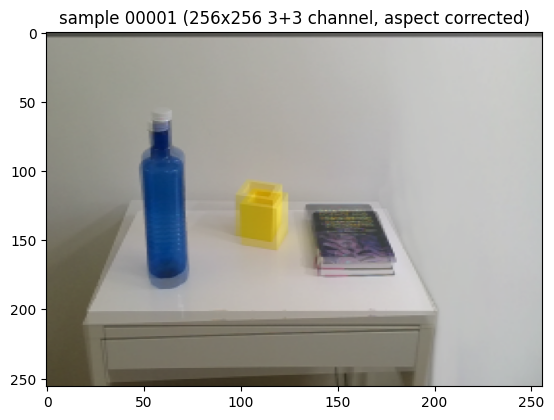

In [159]:
l, r = load_stereo_image(index="00001", dataset_path="/media/emilio/2TBDrive/MUIA-UAX-TFM/natural-dataset", plot=True, roffset=(0,18));
t, q, o = load_target_datapoint("./00001T.bin", dataset_path="/media/emilio/2TBDrive/MUIA-UAX-TFM/natural-dataset")

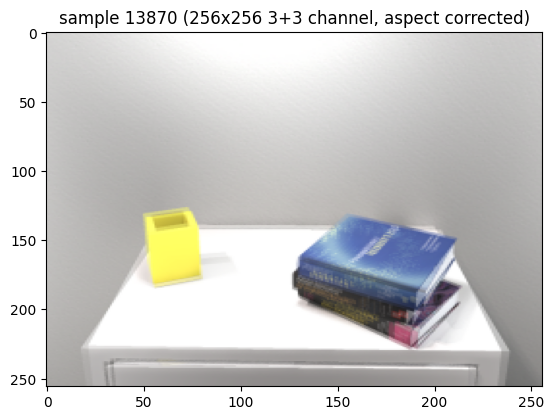

In [158]:
l, r = load_stereo_image(index="13870", dataset_path=DATASET_PATH, plot=True);
t, q, o = load_target_datapoint("./13870T.bin", dataset_path=DATASET_PATH)

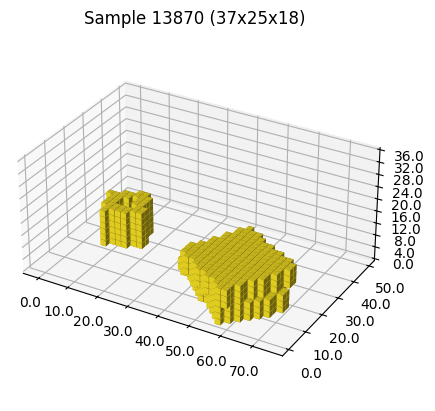

In [90]:
# Now let's have a look at the corresponding ground truth occupation grid

occupation = np.array(o, dtype='float32').reshape(37,25,18)
plot_3d(occupation, aspect='equal')
plt.title(f'Sample 13870 {str(occupation.shape).replace(", ", "x")}');

It's easy to visually match the stereo input image to the output 3d occupancy grid (axis scale in cm)

We need to pad this to 48x48x48 for tensor shape compatibility

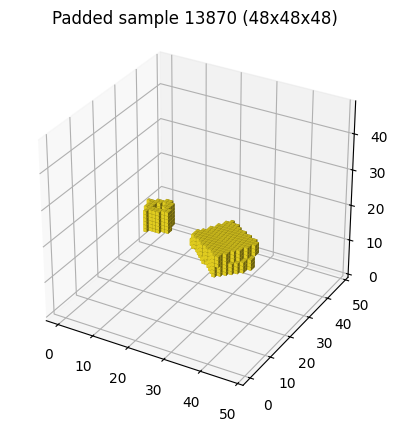

In [91]:
# Padding to 48x48x48

occ_padded = F.pad(torch.tensor(occupation), get_padded_size(np.zeros(occupation.shape), 48))
plot_3d(occ_padded.cpu().numpy(), double_axis=False)
plt.title(f'Padded sample 13870 (48x48x48)');

### Tensor permutation

In order to help the model exploit spaciality, we are going to rearrange the 48x48x48 output tensor (whose axis have been chosen so as to make it easy to visually match the input with the output) so that the two axis of the input images have a simple relationship with the three output axis.

In the input images:
- the 0th axis is the vertical one, and goes from top to bottom
- the 1st axis is the horizontal one, and run from left to right

Whereas in the output plot:
- the 0th axis is the horizontal one, running from left to right
- the 1st axis is the depth one, running from front to back
- the 2nd axis in the vertical one, running from bottom to top

It will be simpler for the model if the 0th and 1st axis were aligned in the input and output tensors, with the need to recreate the 2nd axis from the other two. We are going to apply a transformation to the output data so that these axis match

In [92]:
# A few permutation helper functions

def permute_target_tensor(t):
    return torch.flip(t, dims=[2]).permute(2, 0, 1)

def unpermute_target_tensor(t):
    return torch.flip(t.permute(1, 2, 0), dims=[2])

def crop_output(t):
    return t[6:6+37, 12:12+25, 15:15+18]

def crop_output_batch(t):
    return t[:, 6:6+37, 12:12+25, 15:15+18]

def expand_output(t):
    return F.pad(t, get_padded_size(np.zeros(t.shape), 48))

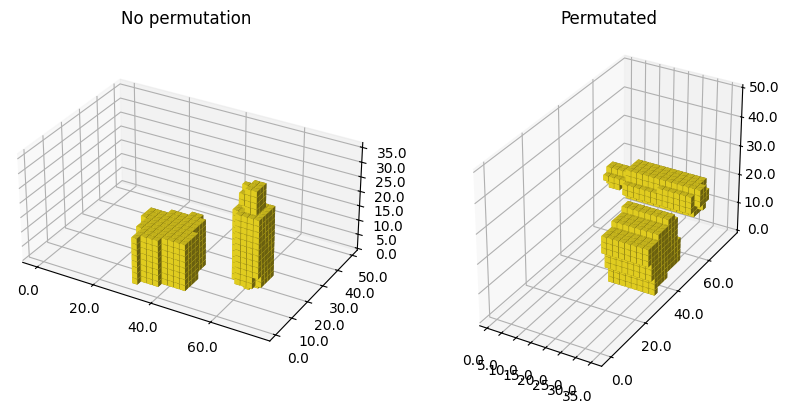

In [93]:
# Permutation of the data channels
t, q, o = load_target_datapoint(os.path.join(DATASET_PATH, "13179T.bin"))

o=np.array(o, dtype='float32').reshape(37,25,18)

# Create a figure with 2 subplots with 3d projection arranged horizontally
fig, axs = plt.subplots(1, 2, subplot_kw={'projection': '3d'}, figsize=(10, 5))

plot_3d(torch.tensor(o).numpy(), ax=axs[0])
axs[0].set_title("No permutation")

plot_3d(permute_target_tensor(torch.tensor(o)).numpy(), ax=axs[1])
axs[1].set_title("Permutated")

# Show the plot
plt.show()

We can now check that in the permutation output, the 0th axis matches the vertical axis running from top to bottom, and the 1st axis runs horizontally from left to right, as in the input 2d image. The 2nd axis could have been inverted so that boths configurations are more easy to match visually, but this won't make a difference when it comes to training the network.

## Dataset normalization
For increased stability, generalization and rapid convergence, let us calculate the mean and standard deviation of the dataset. This mean and std will be single scalars that will be subtracted and divided from the datapoints

## Data Loading
In this section we will prepare the DataLoader pipeline so we can efficiently feed data to the model during training

In [94]:
def make_model_input(l, r, permute=True):
    """Creates a tensor input datapoint to be fed into the model
    from l and r images
    Parameters:
    - l: left image
    - r: right image
    - permute (bool): apply permutation
    Returns:
    torch.tensor
    """
    if permute:
        assert l.shape == (IMG_SIZE, IMG_SIZE, N_CHANNELS//2)
        assert r.shape == (IMG_SIZE, IMG_SIZE, N_CHANNELS//2)
        lr = torch.cat([l, r], dim=2).permute(2,0,1).float()
    else:
        assert l.shape == (N_CHANNELS//2, IMG_SIZE, IMG_SIZE)
        assert r.shape == (N_CHANNELS//2, IMG_SIZE, IMG_SIZE)
        lr = torch.cat([l, r], dim=0).float()
    return lr

In [95]:
def quaternion_to_euler(q):
    w, x, y, z = q
    
    roll = torch.atan2(torch.tensor(2 * (x * y + w * z)), torch.tensor(w**2 + x**2 - y**2 - z**2))
    pitch = torch.asin(torch.clamp(torch.tensor(2 * (x * z - w * y)), -1.0, 1.0))
    yaw = torch.atan2(torch.tensor(2 * (y * z + w * x)), torch.tensor(w**2 - x**2 - y**2 + z**2))
    
    return torch.tensor([roll+np.pi if roll<0 else roll-np.pi, pitch, yaw])

In [194]:
class CustomDataLoader(Dataset):
    """Class to load data from files in disk and convert
    them to tensors on the fly"""
    def __init__(self, data_dir, transform=None, additional_param=None):
        self.data_dir = data_dir
        self.transform = transform
        self.l_img_list = []
        self.r_img_list = []
        self.gt_list = []
        self.return_pose = False
        self.additional_param = additional_param
        max_index = 0
        min_index = 99999999
        for file in sorted(os.listdir(data_dir), reverse=True):
            if file.endswith("L.png"):
                index = int(file.replace("L.png", ""))
                if index>max_index:
                    max_index = index
                if index<min_index:
                    min_index = index
                self.l_img_list.append(os.path.join(data_dir, file))
            elif file.endswith("R.png"):
                self.r_img_list.append(os.path.join(data_dir, file))
            elif file.endswith("T.bin"):
                self.gt_list.append(os.path.join(data_dir, file))   
        print(f"Min index: {min_index},   Max index: {max_index},  N Items: {len(self.l_img_list)}")
        
    def set_return_mode(self, mode, mean=None, std=None):
        self.return_mode = mode
        self.mean = mean
        self.std = std
    
    def __len__(self):
        return len(self.gt_list)

    def __getitem__(self, idx):        
        l, r = load_stereo_image(l_path=self.l_img_list[idx], r_path=self.r_img_list[idx], roffset=(0,42));
        t, q, o = load_target_datapoint(self.gt_list[idx])

        # Apply transformations if specified
        if self.transform:
            l = self.transform(l)
            r = self.transform(r)

        #img = np.zeros((l.shape[0], 2*l.shape[1]))
        #img[:,:l.shape[1]] = l
        #img[:,l.shape[1]:] = r

        l = l.permute(2, 0, 1)
        r = r.permute(2, 0, 1)

        augment_contrast=self.additional_param['contrast'] if (self.additional_param is not None and 'contrast' in self.additional_param) else 0
        augment_saturation=self.additional_param['saturation'] if (self.additional_param is not None and 'saturation' in self.additional_param) else 0
        augment_brightness=self.additional_param['brightness'] if (self.additional_param is not None and 'brightness' in self.additional_param) else 0
        augment_hue=self.additional_param['hue'] if (self.additional_param is not None and 'hue' in self.additional_param) else 0
        augment_noise=self.additional_param['noise'] if (self.additional_param is not None and 'noise' in self.additional_param) else 0

        # Augment each image separately, as l and r cameras are independent

        l = transforms.functional.adjust_brightness(l, 1 + (random.random() - 0.5) * 2 * augment_brightness)
        l = transforms.functional.adjust_contrast(l, 1 + (random.random() - 0.5) * 2 * augment_contrast)
        l = transforms.functional.adjust_saturation(l, 1 + (random.random() - 0.5) * 2 * augment_saturation)
        l = transforms.functional.adjust_hue(l, (random.random() - 0.5) * 2 * augment_hue)
        noise = np.random.normal(0, augment_noise, l.shape).astype(np.float32)
        l = l + noise
        l = torch.clip(l, 0, 1)

        r = transforms.functional.adjust_brightness(r, 1 + (random.random() - 0.5) * 2 * augment_brightness)
        r = transforms.functional.adjust_contrast(r, 1 + (random.random() - 0.5) * 2 * augment_contrast)
        r = transforms.functional.adjust_saturation(r, 1 + (random.random() - 0.5) * 2 * augment_saturation)
        r = transforms.functional.adjust_hue(r, (random.random() - 0.5) * 2 * augment_hue)
        noise = np.random.normal(0, augment_noise, r.shape).astype(np.float32)
        r = r + noise
        r = torch.clip(r, 0, 1)
            
        X = make_model_input(l, r, permute=False)

        if self.return_mode == "position":
            y = np.zeros(3, dtype=np.float32)
            y[0:3] = ((torch.tensor(t)).float())# - self.mean[0:3]) / self.std[0:3]# <1 range
            #y[3:7] = ((torch.tensor(q)).float() - self.mean[3:7]) / self.std[3:7]# <1 range
            #euler_angles = quaternion_to_euler(q)
            #y[3:7] = torch.zeros(4)
            #y[0:3] = ((torch.tensor(t)).float()) # <1 range
            #y[3:7] = ((torch.tensor(q)).float()) # <1 range
            return X,y

        if self.return_mode == "rotation":
            y = np.zeros(3, dtype=np.float32)
            #y[0:3] = ((torch.tensor(t)).float())# - self.mean[0:3]) / self.std[0:3]# <1 range
            #y[3:7] = ((torch.tensor(q)).float() - self.mean[3:7]) / self.std[3:7]# <1 range
            euler_angles = quaternion_to_euler(q)
            y[0:3] = euler_angles.clone().detach()
            #y[0:3] = ((torch.tensor(t)).float()) # <1 range
            #y[3:7] = ((torch.tensor(q)).float()) # <1 range
            return X,y
            
        occupation = torch.tensor(np.array(o, dtype='float32').reshape(37,25,18))
        occupation = expand_output(occupation)
        y = permute_target_tensor(occupation)

        return X, y

In [97]:
TRAIN_DATASET_PATH = "/media/emilio/2TBDrive/robovision_train"
TEST_DATASET_PATH = "/media/emilio/2TBDrive/robovision_test"

aug_params = {
    'contrast': 0.2,
    'brightness': 0.2,
    'saturation': 0.2,
    'hue': 0.2,
    'noise': 0.02
}

dataloader = CustomDataLoader(TRAIN_DATASET_PATH)

Min index: 0,   Max index: 62309,  N Items: 46718


In [98]:
#debug_loader = DataLoader(dataloader)

In [99]:
#for batch in debug_loader:
#    y = batch[1]
#    print(y[0,0,0,0:7])
#    break

In [100]:
# Preprocessing

# Try to load
try:
    pos_weights = torch.load('pos_weights.pt')
except:
    # if error, calculate and save
    dataloader.set_return_mode("occupancy")
    pos_weights = torch.ones((48, 48, 48))
    total = 0
    max_batch = 5000*32
    for batch in dataloader:
        y = batch[1]
        #print(y.shape)
        pos_weights += torch.sum(y, dim=0)
        total += y.shape[0]
        #print(max_batch)
        if (max_batch%5000)==0:
            print(".", end="")
        max_batch-=1
        if max_batch == 0:
            break
    pos_weights = (pos_weights/total) + 1
weights = torch.clamp(1.0 / (pos_weights - 1 + 0.01), max=10)

#Calculemos la media y desviación estándar del vector de pose

In [101]:
# Preprocessing

try:
    with open('./pose_mean.pkl', 'rb') as file:
        pose_mean = pickle.load(file)
    with open('./pose_std.pkl', 'rb') as file:
        pose_std = pickle.load(file)
except:
    pose_data = []
    dataloader.set_return_mode("position")
    pos_weights = torch.ones((48, 48, 48))
    total = 0
    max_batch = 1000
    for batch in dataloader:
        y = batch[1]
        pose_data.append(y)
        if (max_batch%5000)==0:
            print(".", end="")
        max_batch-=1
        if max_batch == 0:
            break
    # We'd better write these down as they are expensive to calculate
    pose_mean = np.mean(np.array(pose_data), axis=0)
    pose_std = np.std(np.array(pose_data), axis=0)
print(pose_mean)
print(pose_std)

[ 3.4469205e+02  7.3269678e+02  4.9531940e+02  1.2743019e-01
  1.2756923e-01 -6.9544047e-01  6.9537848e-01]
[1.5945981e+01 1.9488235e+01 8.6593685e+00 9.9771069e-03 1.0023176e-02
 7.2440053e-03 7.2297286e-03]


## Model
This section will define the model that will be used for the training plus the training function and loss function(s). We will implement the VOXELNet arquitecture here as described in the master's thesis report.

In [102]:
def copy_inflate(input_tensor):
    """
    Inflates towards the 2nd axis by
    producing multiple copies of the
    0th-1st axis slice
    """
    # Get the shape of the input tensor
    batch_size, C, _, N = input_tensor.shape

    # Reshape the input tensor to add a singleton dimension at the end
    inflated_tensor = input_tensor.unsqueeze(-1)

    # Repeat the singleton dimension N times along the last axis
    inflated_tensor = inflated_tensor.expand(-1, -1, -1, -1, N)

    return inflated_tensor


class DoubleConv2D(nn.Module):
    """
    Double Convolution 2D
    """
    def __init__(self, in_channels, out_channels):
        super(DoubleConv2D, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, 3, 1, 1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, 1, 1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
    def forward(self, x):
        x = self.conv1(x)     
        x = self.bn1(x)     
        x = self.relu(x)       
        x = self.conv2(x)      
        x = self.bn2(x)     
        x = self.relu(x)       
        return x

        
class DoubleConv3D(nn.Module):
    """
    Double Convolution 3D
    """
    def __init__(self, in_channels, out_channels):
        super(DoubleConv3D, self).__init__()
        self.double_conv = nn.Sequential(
            nn.Conv3d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm3d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv3d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm3d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

class VoxelNet_v4(nn.Module):
    """
    VoxelNet, U-Net inspired network which will
    map a 6 channel, stereo RGB image into a
    3d 64x64x64 occupation probability map
    """
    def __init__(self, in_channels, out_channels, steps=5):
        super(VoxelNet_v4, self).__init__()

        self.encoder = nn.ModuleList()
        self.decoder = nn.ModuleList()
        self.residual_connections = nn.ModuleList()
        self.steps = steps
        self.relu = nn.ReLU()
        self.elu = nn.ELU()
        self.mode = "occupancy"
        self.pool1d = nn.AvgPool1d(kernel_size=2)

        features = [2 ** (i+4) for i in range(steps)]

        # Encoder
        for feature in features:
            self.encoder.append(
                    DoubleConv2D(in_channels, feature),
            )
            in_channels = feature

        out_ch = in_channels
        
        # Decoder
        for i in range(1,6):
            # Let's try the last layer trick
            self.decoder.append(
                nn.Sequential(
                    nn.ConvTranspose3d(out_ch*2, out_ch, kernel_size=2 if i<5 else 3, stride=2 if i<5 else 3),
                    DoubleConv3D(out_ch, out_ch//2)
                )
            )
            out_ch = out_ch//2
        
        self.pool = nn.MaxPool2d(kernel_size=2)

        self.final_conv_1 = nn.Conv3d(64, 32, kernel_size=1)
        self.final_conv_2 = nn.Conv3d(32, 16, kernel_size=1)
        self.final_conv_3 = nn.Conv3d(16, 4, kernel_size=1)
        self.final_conv_4 = nn.Conv3d(4, out_channels, kernel_size=1)

        self.pose_dense_1 = nn.Linear(2 ** (self.steps+4-1), 256)
        self.pose_dense_2 = nn.Linear(256, 64)
        self.pose_dense_3 = nn.Linear(64, 16)
        self.pose_dense_4 = nn.Linear(16, 7)

    def set_mode(self, mode):
        freeze_pose = True
        if mode=='occupancy':
            freeze_pose = True
        elif mode=='pose' or mode=='position' or mode=='rotation':
            freeze_pose = False
        else:
            raise ValueException("Unknown mode")
        self.mode = mode
        # Freeze layer1 and layer2
        for param in self.encoder.parameters():
            param.requires_grad = freeze_pose
        for param in self.decoder.parameters():
            param.requires_grad = freeze_pose
        for param in self.residual_connections.parameters():
            param.requires_grad = freeze_pose
        for param in self.final_conv_1.parameters():
            param.requires_grad = freeze_pose
        for param in self.final_conv_2.parameters():
            param.requires_grad = freeze_pose
        for param in self.final_conv_3.parameters():
            param.requires_grad = freeze_pose
        for param in self.final_conv_4.parameters():
            param.requires_grad = freeze_pose
        for param in self.pose_dense_1.parameters():
            param.requires_grad = not freeze_pose
        for param in self.pose_dense_2.parameters():
            param.requires_grad = not freeze_pose
        for param in self.pose_dense_3.parameters():
            param.requires_grad = not freeze_pose
        for param in self.pose_dense_4.parameters():
            param.requires_grad = not freeze_pose

    def forward(self, x):

        was_training = self.training
        encoder_outputs = []

        if(self.mode == "pose"):
            # Do not update BatchNormalization Statistics
            self.eval()
            with torch.no_grad():
                # Encoder
                for module in self.encoder:
                    x = module(x)
                    x = self.pool(x)
                    encoder_outputs.append(x)
        else:
            # Encoder
            for module in self.encoder:
                x = module(x)
                x = self.pool(x)
                encoder_outputs.append(x)
        
        if self.mode == "pose":
            if was_training:
                self.train()
            #print(f"{encoder_outputs[-2].shape}")
            s = torch.flatten(encoder_outputs[-2], start_dim=1)
            #print(f"s shape {s.shape}  max {torch.max(s)}   min {torch.min(s)}")
            #x_pose = self.pool1d(s)# + x[:,:,0,0] * 5e7 #x[:,:,0,0]*1e8
            x_pose1 = torch.flatten(encoder_outputs[-2], start_dim=1)
            x_pose2 = torch.flatten(encoder_outputs[-3], start_dim=1)
            x_pose = x[:,:,0,0] #x[:,:,0,0]*1e8
            concatenated = torch.cat((x_pose1, x_pose2, x_pose), dim=1)
            return concatenated
            #x_pose = x[:,:,0,0] * 5e7
            #print(f"x shape {x_pose.shape}  max {torch.max(x_pose)}   min {torch.min(x_pose)} first values {x_pose[:,0:10]}")
            x_pose = self.pose_dense_1(x_pose)
            x_pose = self.elu(x_pose)
            #print(f"1 {x_pose}")
            #if self.pose_dense_1.weight.grad is not None:
            #    print(self.pose_dense_1.weight.grad.detach().cpu().numpy())
            #else:
            #    print(f"pose_dense_1 grad is None")
            x_pose = self.pose_dense_2(x_pose)
            x_pose = self.elu(x_pose)
            #print(f"2 {x_pose}")
            x_pose = self.pose_dense_3(x_pose)
            x_pose = self.elu(x_pose)
            print(f"weights 3: {self.pose_dense_3.weight.detach().cpu().numpy()}")
            #print(f"3 {x_pose}")
            x_pose = self.pose_dense_4(x_pose)
            #print(f"4 {x_pose}")
            if self.pose_dense_4.weight.grad is not None:
                print(f"grad: {self.pose_dense_4.weight.grad.detach().cpu().numpy()}")
            else:
                print(f"pose_dense_4 grad is None")
            print(f"weights 4: {self.pose_dense_4.weight.detach().cpu().numpy()}")
            return x_pose
        x = x.unsqueeze(-1)
        
        # Decoder
        for i in range(1,6):
            residual_connection = encoder_outputs[-i]
            inflated_connection = copy_inflate(residual_connection)
            x = torch.cat([x, inflated_connection], dim=1)
            x = self.decoder[i-1](x)
        
        x = self.final_conv_1(x)
        x = self.relu(x)
        x = self.final_conv_2(x)
        x = self.relu(x)
        x = self.final_conv_3(x)
        x = self.relu(x)
        x = self.final_conv_4(x).squeeze(dim=1)

        return x

In [103]:
model = VoxelNet_v4(in_channels=6, out_channels=1, steps=8).to(device)

# Let's check the number of parameters and memory occupied by the model
count_parameters(model)

(279230528, 1116922112, '279M', '1065MB')

In [104]:
# Let's make one datapoint go through the network to make sure it all tensor shapes
# are coherent
in_data = make_model_input(l, r).unsqueeze(dim=0).to(device)

assert model.forward(in_data).shape == (1, 48, 48, 48)

## Training
This section will include a training function and the appropriate loss function

In [59]:
pos_weight = 0.75
def weighted_cross_entropy_with_logits(logits, labels):
    #log_weight = 1 + (pos_weight - 1) * labels
    log_weight = pos_weight * labels
    loss = (1 - labels) * logits + log_weight * (torch.log1p(torch.exp(-torch.abs(logits))) + F.relu(-logits))
    return loss

In [60]:
from abc import ABC

class Metric(ABC):
    """Abstract metric class, to be inherited from"""
    def __init__(self, name):
        self.channels = {}
        self.name = name

    def initialize(self):
        pass

    def reset(self):
        self.channels = {}

    def print(self):
        if len(self.channels.keys())==0:
            print("<Empty>")
            return
        for channel in self.channels:
            print(f"[{self.name} - {channel}] {self.channels[channel]}")

    def calculate(self, channel, preds, gt, log_to_wandb=False):
        pass

    def append_result(self, channel, value):
        if channel not in self.channels:
            self.channels[channel] = []
        self.channels[channel].append(value)

    def average(self, channel):
        if channel in self.channels:
            total = 0
            for val in self.channels[channel]:
                total += val
            self.channels[channels] = [total / len(self.channels[channel])]

    def log_latest(self, channel, log_to_wandb=False):
        if channel in self.channels and len(self.channels[channel])>0:
            printf(f"[{self.name} - {channel}] {self.channels[channel][-1]}")
            if log_to_wandb:
                wandb.log({'{channel}_{self.name}': self.channels[channel][-1]})

class MisclassificationRate(Metric):
    """Calculates the misclassification rate"""
    def __init__(self, threshold=0.5):
        super().__init__('misclassification_rate')
        self.threshold = threshold
        
    def calculate(self, channel, preds, gt, log_to_wandb=False):
        with torch.no_grad():
            misclassified = 0
            target_class = gt > 0.5
            occ = torch.sigmoid(preds)
            occ = (occ-torch.min(occ)) / (torch.max(occ)-torch.min(occ))
            pred_class = occ > self.threshold
            misclassified = (target_class != pred_class).sum().item()
            self.append_result(channel, misclassified)

class MeanSquaredError(Metric):
    """Calculates the mean squared error"""
    def __init__(self):
        super().__init__('mean_squared_error')
        
    def calculate(self, channel, preds, gt, log_to_wandb=False):
        with torch.no_grad():
            error = (1/preds.shape[0]) * torch.mean((preds-gt)**2)
            self.append_result(channel, error.item())
        

In [61]:
mscr = MisclassificationRate()

In [62]:
# Training function definition

def train_model(model, 
                dloader, 
                optimizer,
                config, 
                val_every_n_minibatches=1, 
                metrics_every_n_minibatches=64,
                start_at=0, 
                initial_epoch=0,
                autosave_every=30, 
                num_epochs=10, 
                device=device, 
                debug=False, 
                name="untitled",
                metrics=[],
                criterion=None,
                suffix="",
                validation=None, 
                log_to_wandb=False, 
                show_grad_norm=False):
    """
    Trains a torch model
    """
    print(f" initial lr: {config['initial_learning_rate']}, weight_decay: {config['weight_decay']}")

    if criterion == None:
        raise ValueException("Criterion must be specified")
    last_lr = config['initial_learning_rate']

    # Agregamos scheduler de tipo ReduceLROnPlateau
    scheduler = ReduceLROnPlateau(optimizer, 
                                  mode='min', 
                                  factor=config['lrfactor'], 
                                  min_lr=config['min_lr'], 
                                  patience=config['patience'])

    dataset_length = None
    epoch_loss = -1
    total_batch_count = 0
    start_time = time.time()
    train_start_time = start_time

    for epoch in range(num_epochs):
        model.train()  # Set the model to training mode
        running_loss = 0.0 # runnin loss is accumulated loss per epoch, we need then to divide per n_minibatches
        val_loss = 0.0
        batch_step = 0
        batch_counter=0
        train_samples = 0
        
        for batch in tqdm(dloader, desc="Epoch", unit="minibatches"): # Takes a minibatch of data
            inputs, targets = batch[0].to(device), batch[1].to(device)
            train_samples += inputs.shape[0]
            optimizer.zero_grad()  # Clears gradients

            outputs = model(inputs) # outputs are predictions
            
            loss = criterion(outputs, targets) # Calculates loss
            loss.backward()  # Backpropagation
            print(loss)
            optimizer.step()  # Updates models parameters

            if val_loss == 0:
                val_loss = loss

            if log_to_wandb:
                wandb.log({'train_loss': loss.item(), 'val_loss': val_loss, 'epoch_loss':epoch_loss, 'lr': last_lr})

            # Calculate metrics
            if total_batch_count%val_every_n_minibatches == (metrics_every_n_minibatches-1):
                with torch.no_grad():
                    for metric in metrics:
                        metric.calculate('train', outputs, targets)
                        metric.log_latest('train', log_to_wandb=log_to_wandb)
            
            running_loss += loss.item()
            #print(f"bc: {batch_counter} / {val_every_n_minibatches}")

            # Calculate validation loss
            if total_batch_count%val_every_n_minibatches == (val_every_n_minibatches-1) and validation!=None:
                model.eval()
                with torch.no_grad():
                    val_batches = 0
                    running_val_loss = 0
                    running_val_mis = 0
                    for batch in validation:

                        val_input, val_targets = batch[0].to(device), batch[1].to(device)
                        val_batches += 1
                        val_pred = model(val_input)

                        val_loss = criterion(val_pred, val_targets) # Calculates loss
                        
                        running_val_loss += val_loss.item()

                        for metric in metrics:
                            metric.calculate('validation', val_pred, val_targets, log_to_wandb=log_to_wandb)
                            metric.log_latest('validation', log_to_wandb=False)

                        print(f"Evaluating batch {val_batches} - val loss: {val_loss}")

                    for metric in metrics:
                        metric.average('validation')
                        metric.log_latest('validation', log_to_wandb=log_to_wandb)
                            
                    if val_batches > 0:
                        val_loss = running_val_loss / val_batches
                        print(f"\nVal loss: {val_loss},  val batches: {val_batches}")
                        
                    model.train() # Back to train mode
           
            batch_step += 1

            # Step the scheduler with the epoch_loss
            scheduler.step(loss.item()) # Actualiza scheduler de LR
            for param_group in optimizer.param_groups: # Lee lr actual
                last_lr = param_group['lr']

            batch_counter += 1
            total_batch_count += 1

            end_time = time.time()
            time_diff = end_time - start_time
            if time_diff > autosave_every:
                checkpoint = {
                    'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                }

                # Save the checkpoint to disk
                torch.save(checkpoint, 
                           "./model_checkpoint_running_m{:}_r{:}_tl{:}_{:.2f}s.pth".format(
                               config['model']+suffix, 
                               name,
                               loss.item(),
                               start_at+end_time-train_start_time))
                start_time = time.time()

        # Epoch completed
        #for metric in metrics:
        #    metric.average('train')
        #    metric.log_latest('train', log_to_wandb=log_to_wandb)
        #    metric.reset()
            
        for param_group in optimizer.param_groups: # Lee lr actual
            last_lr = param_group['lr']
            
        epoch_loss = running_loss / batch_counter
        print(f"\n\n   Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss}, lr: {last_lr}")
        if log_to_wandb:
            wandb.log({'train_loss': loss.item(), 'lr': last_lr})

    torch.save(model.state_dict(), f"./model_checkpoint_finish_{config['model']+suffix}.pth")

In [63]:
config = {
    'initial_learning_rate': 0.0002,
    'weight_decay': 0.00001,
    'lrfactor': 1/1.01,
    'model': 'VoxelNet_v4_2_correct',
    'description': 'With augmentation',
    'experiment': 1,
    'min_lr': 1e-8,
    'patience': 5
}

In [66]:
optimizer = optim.Adam(model.parameters(), lr=config['initial_learning_rate'], weight_decay=config['weight_decay'])

In [34]:
# start a new wandb run to track this script
run = wandb.init(
    # set the wandb project where this run will be logged
    project="MUIA UAX 2023 2024",

    # track hyperparameters and run metadata
    config=config
)

wandb: Currently logged in as: emilio-pomares-porras (quantum_spin_glass). Use `wandb login --relogin` to force relogin


In [35]:
# First, debug training: try to overfit a few samples
# If the model is not capable of doing this, that's a clear
# sign that something is off

train_dataloader = CustomDataLoader(TRAIN_DATASET_PATH, additional_param=aug_params)
train_loader = DataLoader(train_dataloader, batch_size=BATCH_SIZE)

test_dataloader = CustomDataLoader(TEST_DATASET_PATH, additional_param=aug_params)
test_loader = DataLoader(test_dataloader, batch_size=BATCH_SIZE)

Min index: 0,   Max index: 62309,  N Items: 46718
Min index: 5,   Max index: 39822,  N Items: 6296


In [105]:
# Resume training

def find_latest_checkpoint(model_name, directory):
    latest_timestamp = float('-inf')  # Initialize with negative infinity
    latest_file = None

    # Traverse the directory
    for filename in os.listdir(directory):
        if filename.endswith(".pth") and filename.startswith(f"model_checkpoint_running_m{model_name}_"):
            parts = filename.split("_")
            timestamp_str = parts[-1].replace("s.pth", "")
            try:
                timestamp = float(timestamp_str)
                if timestamp > latest_timestamp:
                    latest_timestamp = timestamp
                    latest_file = os.path.join(directory, filename)
            except ValueError:
                pass  # Ignore filenames that can't be parsed as floats

    return latest_file, latest_timestamp

In [106]:
latest_checkpoint, initial_time = find_latest_checkpoint(config['model'], "../checkpoints")
initial_epoch = 0
if latest_checkpoint is not None:
    # Load the weights from the checkpoint file
    print(f"Restoring checkpoint {latest_checkpoint}")
    checkpoint = torch.load(latest_checkpoint)

    # Load the model's state_dict from the checkpoint
    model.load_state_dict(checkpoint['model_state_dict'])
    
    # Read latest epoch
    initial_epoch = checkpoint['epoch']
    
    # Load the optimizer's state_dict from the checkpoint
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
else:
    initial_time = 0

Restoring checkpoint ../checkpoints/model_checkpoint_running_mVoxelNet_v4_2_correct_rmild-bush-51_tl0.006409424357116222_587479.32s.pth


In [ ]:
train_occupancy_model = True
if train_occupancy_model:
    train_model(model,
                train_loader,
                optimizer,
                config,
                val_every_n_minibatches=102400,
                metrics_every_n_minibatches=102400,
                metrics=[mscr],
                start_at=378849,
                initial_epoch=initial_epoch,
                autosave_every=1800,
                num_epochs=1224,
                device=device,
                criterion=nn.BCEWithLogitsLoss(pos_weight=pos_weights),
                debug=False,
                name=run.name,
                validation=test_loader,
                log_to_wandb=True,
                show_grad_norm=True)

In [203]:
def misclassification_rate(predictions, ground_truth):
    """
    Calculate the misclassification rate between predictions and ground truth.
    
    Parameters:
    predictions (torch.Tensor): Tensor containing predicted binary labels (shape: [batch_dim, W, H, D])
    ground_truth (torch.Tensor): Tensor containing ground truth binary labels (shape: [batch_dim, W, H, D])
    
    Returns:
    float: Misclassification rate (incorrect predictions / total elements)
    """
    # Ensure the two tensors have the same shape
    assert predictions.shape == ground_truth.shape, "Shape of predictions and ground_truth must be the same"
    
    # Compare the predictions to the ground truth
    incorrect = torch.ne(predictions, ground_truth)  # Tensor with True where predictions and ground truth differ
    
    # Calculate the number of incorrect predictions
    num_incorrect = incorrect.sum().item()  # Convert to integer
    
    # Calculate total number of elements
    total_elements = ground_truth.numel()  # Total number of elements in the tensor
    
    # Misclassification rate is the number of incorrect predictions divided by total number of elements
    misclassification_rate = num_incorrect / total_elements
    
    return misclassification_rate

def misclassification_rate_with_tolerance(predictions, ground_truth, tol=1e-6):
    """
    Calculate the misclassification rate between predictions and ground truth
    using a tolerance for floating point comparisons.
    
    Parameters:
    predictions (torch.Tensor): Tensor containing predicted binary labels (shape: [batch_dim, W, H, D])
    ground_truth (torch.Tensor): Tensor containing ground truth binary labels (shape: [batch_dim, W, H, D])
    tol (float): Tolerance for floating point comparisons
    
    Returns:
    float: Misclassification rate (incorrect predictions / total elements)
    """
    # Ensure the two tensors have the same shape
    assert predictions.shape == ground_truth.shape, "Shape of predictions and ground_truth must be the same"
    
    # Compare the predictions to the ground truth using a tolerance
    incorrect = ~torch.isclose(predictions, ground_truth, atol=tol)
    
    # Calculate the number of incorrect predictions
    num_incorrect = incorrect.sum().item()
    
    # Calculate total number of elements
    total_elements = ground_truth.numel()
    
    # Misclassification rate is the number of incorrect predictions divided by total number of elements
    misclassification_rate = num_incorrect / total_elements
    
    return misclassification_rate

In [204]:
def precision_recall_f1(predictions, ground_truth, tol=1e-6):
    """
    Calculate precision, recall, and F1 score for binary classification.
    
    Parameters:
    predictions (torch.Tensor): Tensor containing predicted binary labels (shape: [batch_dim, W, H, D])
    ground_truth (torch.Tensor): Tensor containing ground truth binary labels (shape: [batch_dim, W, H, D])
    tol (float): Tolerance for floating point comparisons
    
    Returns:
    tuple: (precision, recall, f1_score)
    """
    # Ensure the two tensors have the same shape
    assert predictions.shape == ground_truth.shape, "Shape of predictions and ground_truth must be the same"
    
    # Use torch.isclose to handle floating-point precision issues
    pred_positives = torch.isclose(predictions, torch.tensor(1.0), atol=tol)
    print(f"pred pos: {pred_positives.sum()}")
    gt_positives = torch.isclose(ground_truth, torch.tensor(1.0), atol=tol)
    print(f"gt posirites: {gt_positives.sum()}")
    
    # Calculate True Positives (TP), False Positives (FP), and False Negatives (FN)
    TP = (pred_positives & gt_positives).sum().item()  # Both predicted and actual are 1
    print(f"TP: {TP}")
    FP = (pred_positives & ~gt_positives).sum().item()  # Predicted 1, but actual is 0
    print(f"FP: {FP}")
    FN = (~pred_positives & gt_positives).sum().item()  # Predicted 0, but actual is 1
    print(f"FN: {FN}")
    
    # Calculate Precision, Recall, and F1 Score
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0.0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0.0
    f1_score = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0.0
    
    return precision, recall, f1_score

In [206]:
loader = test_natural_loader
# Evaluation
total_misc = 0
total_batches = 0
max_batch = 2
for batch in loader:
    pred = crop_output_batch(model(batch[0].to(device)))
    occ = torch.sigmoid(pred)
    occ = (occ-torch.min(occ)) / (torch.max(occ)-torch.min(occ))
    occ = (occ > 0.25) * 1.0 # occ # th
    gt = crop_output_batch(batch[1])
    print(misclassification_rate(occ, gt))
    total_misc += misclassification_rate(occ, gt)
    total_batches += 1
    max_batch -= 1
    if max_batch == 0:
        break
print(f"Misclassification rate in test set: {total_misc/total_batches}")

0.035315315315315315
Misclassification rate in test set: 0.035315315315315315


In [207]:
loader = test_natural_loader
# Evaluation
total_misc = 0
total_batches = 0
max_batch = 30
for batch in loader:
    pred = crop_output_batch(model(batch[0].to(device)))
    occ = torch.sigmoid(pred)
    occ = (occ-torch.min(occ)) / (torch.max(occ)-torch.min(occ))
    occ = (occ > 0.25) * 1.0# * occ # th
    gt = crop_output_batch(batch[1])
    print(misclassification_rate(occ, gt))
    total_misc += misclassification_rate(occ, gt)
    total_batches += 1
    max_batch -= 1
    if max_batch == 0:
        break
print(f"Misclassification rate in test set: {total_misc/total_batches}")

0.03567567567567568
Misclassification rate in test set: 0.03567567567567568


In [208]:
loader = test_natural_loader
# Evaluation
total_p = 0
total_r = 0
total_f1 = 0
total_batches = 0
max_batch = 30
for batch in loader:
    with torch.no_grad():
        pred = crop_output_batch(model(batch[0].to(device)))
        occ = torch.sigmoid(pred)
        occ = (occ-torch.min(occ)) / (torch.max(occ)-torch.min(occ))
        occ = (occ > 0.5) * 1.0# * occ # th
        gt = crop_output_batch(batch[1])
        print(occ.sum())
        print(gt.sum())
        p, r, f1 = precision_recall_f1(occ, gt)
        print(f"{p}, {r}, {f1}")
        total_p += p
        total_r += r
        total_f1 += f1
        total_batches += 1
        max_batch -= 1
        if max_batch == 0:
            break
print(f"Precision, recall, F1 in test set: {total_p/total_batches}, {total_r/total_batches}, {total_f1/total_batches}")

tensor(1592.)
tensor(1128.)
pred pos: 1592
gt posirites: 1128
TP: 863
FP: 729
FN: 265
0.5420854271356784, 0.7650709219858156, 0.6345588235294118
Precision, recall, F1 in test set: 0.5420854271356784, 0.7650709219858156, 0.6345588235294118


In [43]:
train_pose_dataloader = CustomDataLoader(TRAIN_DATASET_PATH, additional_param=aug_params)
train_pose_dataloader.set_return_mode("position", mean=pose_mean, std=pose_std)
train_pose_loader = DataLoader(train_pose_dataloader, batch_size=BATCH_SIZE)

test_pose_dataloader = CustomDataLoader(TEST_DATASET_PATH, additional_param=aug_params)
test_pose_dataloader.set_return_mode("position", mean=pose_mean, std=pose_std)
test_pose_loader = DataLoader(test_pose_dataloader, batch_size=BATCH_SIZE)

Min index: 0,   Max index: 62309,  N Items: 46718
Min index: 5,   Max index: 39822,  N Items: 6296


In [44]:
metr = MeanSquaredError()

In [ ]:
# Camera pose estimation
model.set_mode("occupancy")
metr.reset()
preds = None
gt = None
inp = None
for point in test_pose_loader:
    start_time = time.time()
    inp = point[0][0:8]
    print(model(point[0][0:1]).shape)
    preds = model(point[0][0:1])
    gt = point[1][0:8]
    print(f"Took {(time.time()-start_time)*1000}ms") 
    print(model(point[0][0:8]))
    print(point[1][0:8])
    #metr.calculate("validation", model(point[0][0:1]), point[1][0:1])
    print(point[0][0:1].shape)
    print_layer_output_shapes(model, point[0][0:1])
    break

In [ ]:
preds.dtype

In [ ]:
gt.dtype

In [ ]:
metr.print()

In [ ]:
list_frozen_layers(model)

In [ ]:
wandb.finish()

## Entrenamiento del regresor de pose de camara

In [139]:
train_pose_dataloader = CustomDataLoader(TRAIN_DATASET_PATH, additional_param=aug_params)
train_pose_dataloader.set_return_mode("rotation", mean=pose_mean, std=pose_std)
train_pose_loader = DataLoader(train_pose_dataloader, batch_size=BATCH_SIZE)

test_pose_dataloader = CustomDataLoader(TEST_DATASET_PATH, additional_param=aug_params)
test_pose_dataloader.set_return_mode("rotation", mean=pose_mean, std=pose_std)
test_pose_loader = DataLoader(test_pose_dataloader, batch_size=BATCH_SIZE)

Min index: 0,   Max index: 62309,  N Items: 46718
Min index: 5,   Max index: 39822,  N Items: 6296


In [140]:
for b in train_pose_loader:
    print(b[1])
    break

tensor([[ 6.7658e-03,  3.4395e-01, -1.5393e+00],
        [ 2.5530e-03,  3.6215e-01, -1.5993e+00],
        [-3.0887e-02,  3.3731e-01, -1.5313e+00],
        [-1.7585e-02,  3.6375e-01, -1.5306e+00],
        [ 1.8387e-02,  3.6726e-01, -1.5650e+00],
        [ 2.8124e-03,  3.4879e-01, -1.5414e+00],
        [-1.0800e-02,  3.4186e-01, -1.5579e+00],
        [ 3.7218e-02,  3.5582e-01, -1.5654e+00],
        [ 3.3231e-02,  3.7047e-01, -1.5855e+00],
        [-2.0872e-02,  3.8351e-01, -1.5369e+00],
        [ 3.6759e-02,  3.4777e-01, -1.5955e+00],
        [ 8.5795e-03,  3.7464e-01, -1.5857e+00],
        [-2.0722e-02,  3.3398e-01, -1.5540e+00],
        [ 1.0591e-02,  3.8302e-01, -1.6035e+00],
        [ 5.2149e-03,  3.7612e-01, -1.5888e+00],
        [ 2.3487e-02,  3.6194e-01, -1.6094e+00],
        [-1.5636e-02,  3.5531e-01, -1.5972e+00],
        [ 2.0093e-02,  3.3492e-01, -1.5919e+00],
        [-1.5264e-02,  3.3690e-01, -1.5620e+00],
        [ 1.9480e-02,  3.7265e-01, -1.5703e+00],
        [-8.9767e-03

In [141]:
config = {
    'initial_learning_rate': 0.0001,
    'weight_decay': 0.00001,
    'lrfactor': 1/1.001,
    'model': 'VoxelNet_v4_2_correct-pose-2',
    'description': 'With augmentation',
    'experiment': 1,
    'min_lr': 1e-8,
    'patience': 5
}

In [ ]:
# start a new wandb run to track this script
run = wandb.init(
    # set the wandb project where this run will be logged
    project="MUIA UAX 2023 2024",

    # track hyperparameters and run metadata
    config=config
)

In [ ]:
model.set_mode("pose")
device = "cpu"
model.to(device)
model.train()
optimizer = optim.Adam(model.parameters(), lr=config['initial_learning_rate'], weight_decay=config['weight_decay'])

In [ ]:
latest_checkpoint, initial_time = find_latest_checkpoint(config['model'], "../checkpoints")
initial_epoch = 0
if latest_checkpoint is not None:
    # Load the weights from the checkpoint file
    print(f"Restoring checkpoint {latest_checkpoint}")
    checkpoint = torch.load(latest_checkpoint)

    # Load the model's state_dict from the checkpoint
    model.load_state_dict(checkpoint['model_state_dict'])
    
    # Read latest epoch
    initial_epoch = checkpoint['epoch']
    
    # Load the optimizer's state_dict from the checkpoint
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
else:
    initial_time = 0

In [ ]:
model.set_mode("pose")
device = "cuda:0"
model.to(device)

In [ ]:
list_frozen_layers(model)

In [ ]:
model.set_mode("pose")
device = "cpu"
model.to(device)
model.train()

In [ ]:
train_model(model,
            train_pose_loader,
            optimizer,
            config,
            val_every_n_minibatches=1024,
            metrics_every_n_minibatches=1024,
            metrics=[],
            start_at=11667,
            initial_epoch=initial_epoch,
            autosave_every=1800,
            num_epochs=1,
            device=device,
            criterion=nn.MSELoss(),
            debug=False,
            name=run.name,
            validation=test_pose_loader,
            log_to_wandb=True,
            show_grad_norm=True)

In [ ]:
m=1
for b in train_pose_loader:
    print(model(b[0][0:3].to(device)))
    print(b[1][0:3])
    m-=1
    if m==0:
       break

In [ ]:
checkpoint = {
                    'epoch': 20,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                }
torch.save(checkpoint, "pose-train-1.pch")

In [ ]:
checkpoint = torch.load("pose-train-1.pch")

# Load the model's state_dict from the checkpoint
model.load_state_dict(checkpoint['model_state_dict'])

## Evaluation of trained model

Let's have a look at how does the model reconstruct points in the test set

In [49]:
def strip_model(model):
    """
    Strips a PyTorch model of all gradient information and moves it to CPU.

    Args:
        model (torch.nn.Module): The PyTorch model to be stripped.

    Returns:
        torch.nn.Module: The stripped model moved to CPU.
    """
    # Step 1: Detach the parameters and buffers from the computational graph
    for param in model.parameters():
        param.requires_grad = False

    for buffer in model.buffers():
        buffer.requires_grad = False

    # Step 2: Move the model to CPU (if necessary)
    model_cpu = model.cpu()

    # Return the stripped model
    return model_cpu

In [187]:
TEST_DATASET_PATH = "/media/emilio/2TBDrive/MUIA-UAX-TFM/natural-dataset"

test_natural_dataloader = CustomDataLoader(TEST_DATASET_PATH, additional_param=aug_params)
test_natural_dataloader.set_return_mode("occupancy")
test_natural_loader = DataLoader(test_natural_dataloader, batch_size=2)

Min index: 1,   Max index: 2,  N Items: 2


In [188]:
device = "cpu"

In [189]:
model.set_mode("occupancy")

In [190]:
#model = strip_model(model)

In [195]:
model_device = model.to(device)

torch.Size([2, 6, 256, 256])
torch.Size([2, 48, 48, 48])
Inference time: 497.3995770001238ms


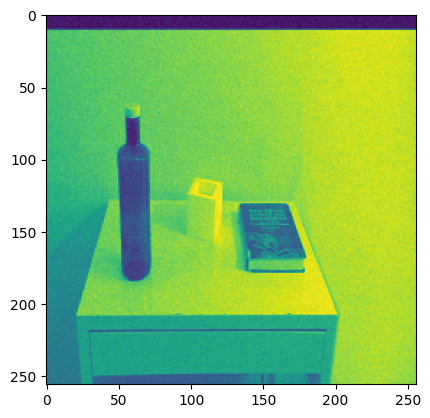

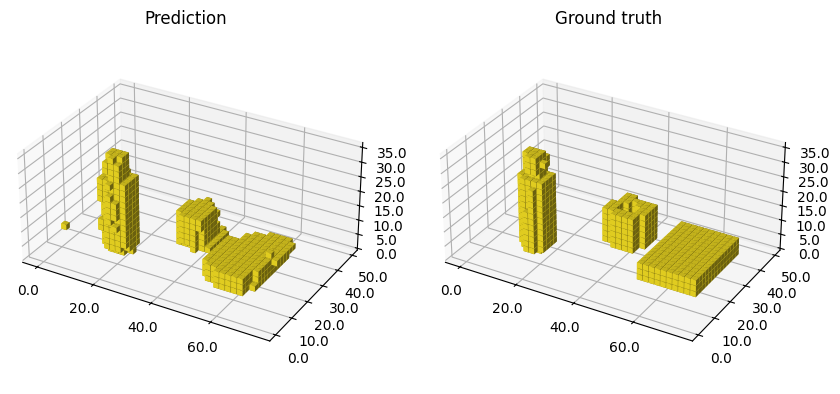

0.02486997885000619


In [201]:
th = nn.Threshold(0.5, 0)
inference_times = 0
max_tries = 1
with torch.no_grad():
    idx = 1
    model_device.eval()
    for batch in test_natural_loader:
        X = batch[0].to(device)
        y = batch[1].to(device)
        print(X.shape)
        print(y.shape)
        plt.imshow(X[idx,0].detach().cpu())
        plt.imshow(X[idx,1].detach().cpu())
        start_time = time.perf_counter() # PERF
        pred = model_device(X[idx:idx+1])
        end_time = time.perf_counter() # PERF
        execution_time = end_time - start_time # PERF
        inference_times += execution_time
        print(f"Inference time: {execution_time*1000}ms")
        occ = torch.sigmoid(pred)[0]
        occ = (occ-torch.min(occ)) / (torch.max(occ)-torch.min(occ))
        occ = (occ > 0.85) * 1.0 # th
        
        # Create a figure with 2 subplots with 3d projection arranged horizontally
        fig, axs = plt.subplots(1, 2, subplot_kw={'projection': '3d'}, figsize=(10, 5))
        
        plot_3d(crop_output(unpermute_target_tensor(occ.cpu())).detach().numpy(), ax=axs[0])
        axs[0].set_title("Prediction")
        
        plot_3d(crop_output(unpermute_target_tensor(y[idx].cpu())).detach().numpy(), ax=axs[1])
        axs[1].set_title("Ground truth")
        
        # Show the plot
        plt.show()

        if max_tries == 0:
            break
        max_tries -= 1
        idx += 1
print(inference_times/20)

In [197]:
for batch in debug_train_loader:
    print(batch[0].shape)
    print(batch[1].shape)
    break

NameError: name 'debug_train_loader' is not defined


## Evaluation and metrics

In [ ]:
my_weights=torch.tensor([10, 1, 1, 11])

In [ ]:
my_truth = torch.tensor([[1., 0., 0., 1.], [0., 0., 1., 0.]]).float()

In [ ]:
my_preds = torch.tensor([[30, 0.34, -2, -40], [-10, -3, 4, -1]]).float()

In [ ]:
nn.BCEWithLogitsLoss(pos_weight=my_weights)(my_preds, my_truth)

In [ ]:
model.eval()

In [ ]:
model.set_mode("pose")
for b in train_pose_loader:
    print(model(b[0].to(device)))
    break

In [147]:
# Make precooked datasets for faster training
model = strip_model(model)
device = "cpu"
model.to(device)
model.set_mode("pose")
model.eval()
tensor_list = []
output_list = []
m = 60
for b in tqdm(test_pose_loader):
    tensor_list.append(model(b[0].to(device)).cpu().detach())
    output_list.append(b[1])
    m -= 1
    if m==0:
        break
latent_dataset_X = torch.cat(tensor_list)
latent_dataset_y = torch.cat(output_list)

 30%|█████████████████████████▏                                                          | 59/197 [06:32<15:19,  6.66s/it]


In [143]:
latent_dataset_X.shape

torch.Size([3200, 14336])

(array([  1.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   1.,   0.,
          1.,   0.,   1.,   2.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,
          3.,   0.,   1.,   1.,   2.,   1.,   2.,   3.,   2.,   2.,   8.,
         10.,  16.,  15.,  22.,  35.,  33.,  44.,  81.,  82., 122., 184.,
        265., 324., 400., 410., 401., 296., 179.,  80.,  57.,  42.,  21.,
         12.,  11.,  10.,  10.,   2.,   2.,   0.,   0.,   1.]),
 array([0.20334415, 0.21640639, 0.22946864, 0.24253088, 0.25559312,
        0.26865539, 0.28171763, 0.29477987, 0.30784211, 0.32090437,
        0.33396661, 0.34702885, 0.36009109, 0.37315333, 0.3862156 ,
        0.39927784, 0.41234007, 0.42540231, 0.43846458, 0.45152682,
        0.46458906, 0.4776513 , 0.49071354, 0.50377578, 0.51683801,
        0.52990031, 0.54296255, 0.55602479, 0.56908703, 0.58214927,
        0.59521151, 0.60827374, 0.62133598, 0.63439822, 0.64746052,
        0.66052276, 0.673585  , 0.68664724, 0.69970948, 0.71277171,
        0.72583395, 0.

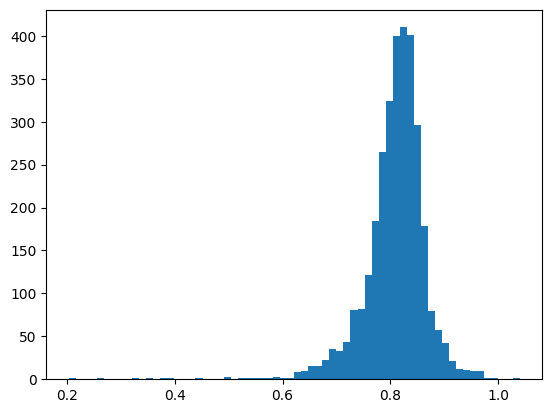

In [144]:
plt.hist(latent_dataset_X[:,8899], bins=64)

In [145]:
latent_dataset_y

tensor([[ 0.0068,  0.3440, -1.5393],
        [ 0.0026,  0.3622, -1.5993],
        [-0.0309,  0.3373, -1.5313],
        ...,
        [-0.0358,  0.3662, -1.5468],
        [-0.0294,  0.3285, -1.5541],
        [-0.0100,  0.3915, -1.5571]])

In [148]:
# Save tensors
torch.save(latent_dataset_X, "latent_X_rot_v2_t.pth")
torch.save(latent_dataset_y[:,0:3], "latent_y_rot_v2_t.pth")

In [125]:
xxx = torch.load("latent_y_v5.pth")

In [133]:
torch.max(xxx[:,0])-torch.min(xxx[:,0])

tensor(69.2709)

In [ ]:
------------------------------------------------------------------------------------------------------------------------------------------

In [134]:
xxx = torch.load("latent_y_rot_v1.pth")

In [136]:
xxx[0:3]

tensor([[-3.1348,  0.3440, -1.5393],
        [-3.1390,  0.3622, -1.5993],
        [ 3.1107,  0.3373, -1.5313]])